# Test on Metabric

In [1]:
import numpy

In [2]:
import sklearn

In [3]:
import survhive

In [4]:
survhive.list_available_datasets()

('flchain', 'gbsg2', 'metabric', 'support')

In [5]:
mb_df = survhive.get_data('metabric')
mb_df.dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1903 entries, 0 to 1902
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   hormone_treatment  1903 non-null   float64
 1   radiotherapy       1903 non-null   float64
 2   chemoterapy        1903 non-null   float64
 3   ER-positive        1903 non-null   float64
 4   MKI67              1903 non-null   float64
 5   EGFR               1903 non-null   float64
 6   PGR                1903 non-null   float64
 7   ERBB2              1903 non-null   float64
 8   AOD                1903 non-null   float64
 9   time               1903 non-null   float64
 10  event              1903 non-null   int64  
dtypes: float64(10), int64(1)
memory usage: 178.4 KB


In [6]:
X, y = mb_df.get_X_y()
X.shape, y.shape

((1903, 9), (1903,))

In [7]:
y[:10]

array([(False,  99.33333588), ( True,  95.73332977),
       (False, 140.2333374 ), (False, 239.30000305),
       ( True,  56.93333435), (False, 123.53333282),
       (False, 261.20001221), ( True, 143.        ),
       ( True, 150.6000061 ), ( True,  49.43333435)],
      dtype=[('event', '?'), ('time', '<f8')])

### Generate a (stratified) train-test split and Scale the features (only) 

First do the stratified splitting THEN do scaling, parameterized on X_train set ONLY 

In [8]:
from sklearn.preprocessing import StandardScaler, RobustScaler

In [9]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y,
                                                                            stratify=survhive.get_indicator(y), 
                                                                           random_state=2309)

In [10]:
scaler = StandardScaler().fit(X_train)
[X_train, X_test] = [ scaler.transform(_) for _ in  [X_train, X_test] ]
X_train.shape, X_test.shape

((1427, 9), (476, 9))

In [11]:
#X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y)

balanced partitioning OK. Robst scaler damages the performance of DSM A LOT.
maybe did something wrong. It is standard scaler for now.

In [12]:
survhive.get_indicator(y).sum(), survhive.get_indicator(y_train).sum(), survhive.get_indicator(y_test).sum(),


(1103, 827, 276)

## check possible dimensionality reduction

In [13]:
from sklearn.decomposition import PCA

In [14]:
pca= PCA(n_components=0.995, random_state=2308).fit(X_train)
print('PCA components:',pca.n_components_)

PCA components: 9


No reduction using PCA

In [15]:
## Stratified CV spliter for survival analysis

In [16]:
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold

In [17]:
#testkf= RepeatedStratifiedKFold(n_splits=5,n_repeats=2,random_state=2307)
#for trn,tst in testkf.split(X_train, survhive.get_indicator(y_train)):
#    print(trn,tst) 

# test coxnet

In [18]:
coxnet = survhive.CoxNet(rng_seed=2308)
coxnet.fit(X_train, y_train)

CoxNet(rng_seed=2308, l1_ratio=0.5, verbose=False, fit_baseline_model=False)

In [19]:
coxnet.score(X_test, y_test)

0.6454275957822058

In [20]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [30]:
def optimize(estimator, X, y, mode='sklearn-grid', user_grid=[] , cv=None, n_jobs=1):
    if mode == 'sklearn-grid':
        if not user_grid: 
            user_grid = estimator.get_parameter_grid()
        gs = GridSearchCV(estimator, user_grid, refit=True, cv=cv, n_jobs=n_jobs)
        gs.fit(X, y)
        return gs.best_estimator_, gs.best_params_, gs
    raise ValueError(f'unknown mode parameter: "{mode}"')

In [22]:
survhive.CoxNet().get_parameter_grid()

{'l1_ratio': [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]}

In [33]:
opt_coxnet, opt_coxnet_params, opt_coxnet_search = optimize(survhive.CoxNet(), X_train, y_train, user_grid={'l1_ratio':[0.01,0.25,0.5,0.75,0.8,0.99]}, n_jobs=4,
                                                           cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=2308).split(X_train,survhive.get_indicator(y_train)))
opt_coxnet.score(X_test, y_test), opt_coxnet_params

(0.6457778278109247, {'l1_ratio': 0.01})

In [68]:
cv_res = opt_coxnet_search.cv_results_
rez=sorted(zip(cv_res['rank_test_score'], cv_res['mean_test_score'] , 
               cv_res['std_test_score'], ))
rez[:10]

[(1, 0.6327164669243752, 0.016072292742850384),
 (2, 0.6325177836040132, 0.016135021436762733),
 (3, 0.6323378940201726, 0.016242522405838608),
 (4, 0.6322963996059433, 0.016315316009570185),
 (5, 0.6322855155375182, 0.016290346961427334),
 (6, 0.6322354216960684, 0.016235613376322722)]

In [24]:
def test_model(model_constructor, **model_params):
    m = model_constructor(**model_params)
    m.fit(X_train, y_train)
    o = m.score(X_train, y_train)
    s = m.score(X_test, y_test)
    print(f'Train: {o: .4f} , Test: {s:.4f}')
    return s

# Test DSM

In [25]:
batch10 = int(X_train.shape[0] /10 ) 

In [26]:
grid =survhive.DeepSurvivalMachines.get_parameter_grid()
grid

{'n_distr': [2],
 'distr_kind': ['Weibull'],
 'batch_size': [16],
 'layer_sizes': [[10]],
 'learning_rate': [0.001],
 'validation_size': [0.1],
 'max_epochs': [10],
 'elbo': [False]}

In [27]:
xpl=survhive.DeepSurvivalMachines(n_distr=2,layer_sizes=[6], 
                                  max_epochs=50, batch_size=32,
                                 rng_seed=2309)
xpl

DeepSurvivalMachines(rng_seed=2309, n_distr=2, distr_kind='Weibull', batch_size=32, layer_sizes=[6], learning_rate=0.001, validation_size=0.1, max_epochs=50, elbo=False)

In [28]:
zzz= xpl.fit(X_train,y_train)
zzz.model_.fitted

 26%|███████████████                                           | 13/50 [00:01<00:04,  7.47it/s]


True

In [43]:
zzz.predict(X_test, eval_times=None)

array([0.51743684, 0.39865634, 0.51294601, 0.52600467, 0.57710727,
       0.28325232, 0.18112254, 0.5109541 , 0.30667376, 0.38728598,
       0.45982623, 0.19326165, 0.17162027, 0.45126313, 0.1340118 ,
       0.18240573, 0.64186201, 0.37462562, 0.48412323, 0.46589768,
       0.09776113, 0.25075281, 0.51886168, 0.2318195 , 0.18262675,
       0.50900534, 0.57399659, 0.37342292, 0.6204755 , 0.57630948,
       0.45935399, 0.51501477, 0.45101345, 0.50515609, 0.42128875,
       0.32124713, 0.44162069, 0.31485687, 0.5998718 , 0.38368833,
       0.29413457, 0.19442544, 0.58137982, 0.25055378, 0.57186053,
       0.39984265, 0.20987268, 0.51931762, 0.24940009, 0.48397851,
       0.48158839, 0.17289804, 0.51782287, 0.31974949, 0.43186709,
       0.55856882, 0.28204483, 0.27131825, 0.16623501, 0.61035526,
       0.13274965, 0.41615741, 0.54888057, 0.49206395, 0.51151038,
       0.56460254, 0.56138959, 0.31406561, 0.32471529, 0.23036438,
       0.3718705 , 0.13960503, 0.41824658, 0.28836958, 0.39303

In [30]:
#test_model(survhive.DeepSurvivalMachines, batch_size=32, layer_sizes=[6], n_distr=1, 
           #elbo=True, max_epochs=50)

In [88]:
#test_model(survhive.DeepSurvivalMachines, batch_size=16, layer_sizes=[7,7,7], n_distr=2, max_epochs=200)

In [29]:
test_model(survhive.DeepSurvivalMachines, batch_size=batch10, layer_sizes=[5]*5, n_distr=2, max_epochs=200)

 34%|███████████████████▍                                     | 68/200 [00:02<00:05, 23.12it/s]


Train:  0.6179 , Test: 0.6120


0.6120429784732385

In [32]:
test_model(survhive.DeepSurvivalMachines,layer_sizes=[41], max_epochs=200)

  4%|█████▊                                                                                                                            | 9/200 [00:00<00:16, 11.53it/s]

Train:  0.6563 , Test: 0.6591


0.6590616283287678

In [39]:
grid['n_distr']=[1,2]
some_primes = list(range(3,10))
grid['layer_sizes']=[ [_] for _ in some_primes] + [ [_]*2 for _ in some_primes] + [ [_]*3 for _ in some_primes]
    #[31]*2,[29]*2,[27]*2, [25]*2, [23]*2, [21]*2, [19]*2, [17]*3, [15]*3, 
     #                [12]*4, [10]*5, [8]*6, [7]*7, ]
    #[40],[30,30], [30], [23,23], [13,13,13], [25],[11,11,11],[20],[9,9,9], 
                     #[15],[7,7,7],[10],[5,5,5]]
                     #[16],[14,14], [7,7,7]]
grid['max_epochs']=[100]
grid['batch_size']=[32]
grid

{'n_distr': [1, 2],
 'distr_kind': ['Weibull'],
 'batch_size': [32],
 'layer_sizes': [[3],
  [4],
  [5],
  [6],
  [7],
  [8],
  [9],
  [3, 3],
  [4, 4],
  [5, 5],
  [6, 6],
  [7, 7],
  [8, 8],
  [9, 9],
  [3, 3, 3],
  [4, 4, 4],
  [5, 5, 5],
  [6, 6, 6],
  [7, 7, 7],
  [8, 8, 8],
  [9, 9, 9]],
 'learning_rate': [0.001],
 'validation_size': [0.1],
 'max_epochs': [100],
 'elbo': [False]}

In [45]:
from sklearn.model_selection import RepeatedStratifiedKFold 

In [33]:
# Non stratified CV
#opt_dsm, opt_dsm_params, opt_dsm_search = optimize(survhive.DeepSurvivalMachines(rng_seed=2308),  X_train, y_train, 
#                                                   user_grid=grid,cv=RepeatedKFold(n_splits=5, n_repeats=3, random_state=2308))
#opt_dsm.score(X_test, y_test), opt_dsm_params

In [40]:
# Stratified CV
opt_dsm, opt_dsm_params, opt_dsm_search = optimize(survhive.DeepSurvivalMachines(rng_seed=2308),  X_train, y_train, n_jobs=8,
                                                   user_grid=grid,cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=2308).split(X_train,survhive.get_indicator(y_train)))
opt_dsm.score(X_test, y_test), opt_dsm_params

 23%|█████████████                                            | 23/100 [00:03<00:10,  7.30it/s]


(0.6665853628028569,
 {'batch_size': 32,
  'distr_kind': 'Weibull',
  'elbo': False,
  'layer_sizes': [7],
  'learning_rate': 0.001,
  'max_epochs': 100,
  'n_distr': 2,
  'validation_size': 0.1})

In [42]:
cv_res = opt_dsm_search.cv_results_
rez=sorted(zip(cv_res['rank_test_score'], cv_res['mean_test_score'] , cv_res['std_test_score'], 
               cv_res['mean_test_score'] - cv_res['std_test_score'], opt_dsm_search.cv_results_['params']))
rez[:10]

[(1,
  0.6439123236055904,
  0.013331054406781466,
  0.6305812691988089,
  {'batch_size': 32,
   'distr_kind': 'Weibull',
   'elbo': False,
   'layer_sizes': [7],
   'learning_rate': 0.001,
   'max_epochs': 100,
   'n_distr': 2,
   'validation_size': 0.1}),
 (2,
  0.641216329625738,
  0.013656838752293343,
  0.6275594908734448,
  {'batch_size': 32,
   'distr_kind': 'Weibull',
   'elbo': False,
   'layer_sizes': [8, 8, 8],
   'learning_rate': 0.001,
   'max_epochs': 100,
   'n_distr': 2,
   'validation_size': 0.1}),
 (3,
  0.6410448389376093,
  0.01578927172475547,
  0.6252555672128539,
  {'batch_size': 32,
   'distr_kind': 'Weibull',
   'elbo': False,
   'layer_sizes': [6, 6],
   'learning_rate': 0.001,
   'max_epochs': 100,
   'n_distr': 2,
   'validation_size': 0.1}),
 (4,
  0.6401690073828874,
  0.0085377368984144,
  0.631631270484473,
  {'batch_size': 32,
   'distr_kind': 'Weibull',
   'elbo': False,
   'layer_sizes': [6],
   'learning_rate': 0.001,
   'max_epochs': 100,
   'n_dist

In [43]:
low_bound = sorted(rez[:10], key= lambda k: k[3], reverse=True)
for lb in [ _ for _ in low_bound if _[3] > 0.5] :
    print(lb[0:4])
    test_model(survhive.DeepSurvivalMachines, **lb[4])

(4, 0.6401690073828874, 0.0085377368984144, 0.631631270484473)


 13%|███████▍                                                 | 13/100 [00:01<00:12,  7.19it/s]


Train:  0.6486 , Test: 0.6522
(1, 0.6439123236055904, 0.013331054406781466, 0.6305812691988089)


 23%|█████████████                                            | 23/100 [00:02<00:09,  7.86it/s]


Train:  0.6579 , Test: 0.6666
(2, 0.641216329625738, 0.013656838752293343, 0.6275594908734448)


 26%|██████████████▊                                          | 26/100 [00:03<00:10,  7.01it/s]


Train:  0.6614 , Test: 0.6682
(5, 0.6392439596135209, 0.013189568452178372, 0.6260543911613425)


 33%|██████████████████▊                                      | 33/100 [00:04<00:08,  7.73it/s]


Train:  0.6625 , Test: 0.6661
(7, 0.6373802236649386, 0.011519852514337724, 0.6258603711506009)


 13%|███████▍                                                 | 13/100 [00:01<00:10,  8.47it/s]


Train:  0.6424 , Test: 0.6341
(10, 0.6355773888965156, 0.010116405584353453, 0.6254609833121622)


 15%|████████▌                                                | 15/100 [00:01<00:11,  7.71it/s]


Train:  0.6481 , Test: 0.6642
(3, 0.6410448389376093, 0.01578927172475547, 0.6252555672128539)


 13%|███████▍                                                 | 13/100 [00:01<00:12,  6.90it/s]


Train:  0.6500 , Test: 0.6492
(6, 0.6374513258647787, 0.012825806218798695, 0.62462551964598)


 14%|███████▉                                                 | 14/100 [00:02<00:13,  6.42it/s]


Train:  0.6542 , Test: 0.6551
(9, 0.6356634920689161, 0.011565403723919947, 0.6240980883449962)


 13%|███████▍                                                 | 13/100 [00:02<00:13,  6.44it/s]


Train:  0.6482 , Test: 0.6479
(8, 0.6358725130321964, 0.01804665694618733, 0.617825856086009)


 33%|██████████████████▊                                      | 33/100 [00:03<00:07,  9.08it/s]

Train:  0.6583 , Test: 0.6545


In [53]:
test_model(survhive.DeepSurvivalMachines, batch_size=32, layer_sizes=[7], n_distr=2, max_epochs=200)

 12%|██████████████▊                                                                                                                  | 23/200 [00:01<00:14, 11.87it/s]

Train:  0.6579 , Test: 0.6666


0.6665853628028569

# Appunti di varie prove DSM

## Insieme di prova (Breast cancer)

Piccolo insieme bastardo. 200 elementi, 84 features e solo il 25% di eventi non censurati.
Coxnet di default va male (c-index 53%), DSM richiede cura per inziare a generalizzare.

## Stabilità risultato

1. stratificare, stratificare rispetto all'evento. Usando insiemi stratificati rispetto all'evento DSM inizia a funzionare in maniera meno erratica.
2. Se si stratifica anche la CV, L'ottimizzazione DSM tende a fornire risultati buoni per tutta le soluzioni top e anche CoxNet ci guadagna in ottimizzazione (c-index: 57%).
   potrebbe sembrare ovvio a posteriori, dato che stiamo imponendo un "contenuto di informazione" simile tra train e test. ma non mi pare una forzatura clamorosa.

# Ottimizzazione parametri DSM

1. Quello più difficile da gestire è ovviamente la topologia della rete. Usando un solo strato nascosto si vede che anche cambiando di un solo valore la dimensione si può passare da una rete che generalizza a una che fa schifo, quindi bisognerebbe fare uno scan senza salti. O fare una random search.
   Alla fine mi sono inventato un protocollo scemo ma che sembra andare ragionevolmente (su breast cancer). Fare uno scan per i valori de numeri primi compresi tra 3 e n_features/2 (olè!)
2. Reti a "parametri equivalenti", (la procedura del quant): fatti tanti test, c'è un fenomeno curioso: le reti con numero pari di strarti nascosti generalizzano male. Mah!
   Quindi alla fine ho testato sistematicamente solo quelle con strati dispari (1,3,5). Ma per quelle con 5 iniziano ad apparire problemi di stabilità numerica, probabilmente quando sono troppo grandi.
3. numero di funzioni di base (Weibull): il default è 2, ma si ottengono parecchi buoni risultati anche con una sola. Molte soluzioni con 3 non generalizzano. quindi 1 o 2.
4. Come detto sopra, la stratificazione aiuta molto, così come il fare almeno 10 split (n_splits=5, n_repeats=2) per aver una varianza abbastanza stabile. Sono riuscito a fare griglie con cv stratificate con un trucchino sklearn che implementerei
5. batch size: 10% dell'insieme di train. Sembra OK. mai ottimizzata. così come gli altri parametri legati al learning. Non mi aspetto che incidano.
6. Alla fine della fiera si possono ottenere risulati stabilmente decorosi usando 1 o 3 strati nascosto e 1 sola weibull (test c-index: 65%). Introducendo anche la doppia weibull la griglia diventa più onerosa e possono aumentare le soluzioni solo apparentemente buone ma generalizzano peggio (anche se non disastrose: 58%). Non andare oltre le 2 weibull e 3 strati.


# PyCox

In [55]:
#import pycox.models

In [47]:
dhs = survhive.DeepHitSingle()
dhs

DeepHitSingle(rng_seed=-1, num_durations=10, layer_sizes=[10, 10], epochs=10, batch_size=16, validation_size=0.1, learning_rate=0.001, dropout=0.1, device='cpu')

In [55]:
# WARNING: if num_cpus is defined in GridSearchCV it dies in the first run of DHS fit, probably bc it wants all cpus for itself
def optimize(estimator, X, y, mode='sklearn-grid', user_grid=[] , cv=None):
    if mode == 'sklearn-grid':
        if not user_grid: 
            user_grid = estimator.get_parameter_grid()
        gs = GridSearchCV(estimator, user_grid, refit=True, cv=cv)
        gs.fit(X, y)
        return gs.best_estimator_, gs.best_params_, gs
    raise ValueError(f'unknown mode parameter: "{mode}"')

In [48]:
dhs_grid = dhs.get_parameter_grid()
dhs_grid

{'num_durations': [10],
 'layer_sizes': [[10, 10]],
 'epochs': [100],
 'batch_size': [16]}

In [52]:
test_model(survhive.DeepHitSingle, rng_seed=2309, batch_size=32, num_durations=10, epochs=50, dropout=0.2, validation_size=0.2,
           learning_rate=0.005, layer_sizes=[9],)

Train:  0.6324 , Test: 0.6327


0.632731684741141

In [62]:
dhs_grid['num_durations'] =[10]
#some_primes = [5,7,11,13,17,19,23,29,31,37,41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83] 
some_primes = list(range(3,10))
dhs_grid['layer_sizes']=[ [_] for _ in some_primes
                            + [ [_]*2 for _ in some_primes]
                          + [ [_]*3 for _ in some_primes]
                        ]
#dhs_grid['layer_sizes'] =[[23], [19]*2, [10]*3, [7]*4, [5]*5]
dhs_grid['epochs']=[50]
dhs_grid['dropout']=[0.1, 0.2 , 0.3]
dhs_grid['learning_rate']=[0.005]
dhs_grid['rng_seed']=[2309]
dhs_grid['batch_size']=[32]
dhs_grid

{'num_durations': [10],
 'layer_sizes': [[3],
  [4],
  [5],
  [6],
  [7],
  [8],
  [9],
  [[3, 3]],
  [[4, 4]],
  [[5, 5]],
  [[6, 6]],
  [[7, 7]],
  [[8, 8]],
  [[9, 9]],
  [[3, 3, 3]],
  [[4, 4, 4]],
  [[5, 5, 5]],
  [[6, 6, 6]],
  [[7, 7, 7]],
  [[8, 8, 8]],
  [[9, 9, 9]]],
 'epochs': [50],
 'batch_size': [32],
 'dropout': [0.1, 0.2, 0.3],
 'learning_rate': [0.005],
 'rng_seed': [2309]}

In [63]:
opt_dhs, opt_dhs_params, opt_dhs_search = optimize(dhs,  X_train, y_train,
                                                   user_grid=dhs_grid,cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=2308).split(X_train,survhive.get_indicator(y_train)))
opt_dhs.score(X_test, y_test), opt_dhs_params

(0.6449147560258671,
 {'batch_size': 32,
  'dropout': 0.1,
  'epochs': 50,
  'layer_sizes': [6],
  'learning_rate': 0.005,
  'num_durations': 10,
  'rng_seed': 2309})

In [64]:
dhs_res = opt_dhs_search.cv_results_
rez=sorted(zip(dhs_res['rank_test_score'], dhs_res['mean_test_score'] , dhs_res['std_test_score'], 
               dhs_res['mean_test_score'] - dhs_res['std_test_score'], opt_dhs_search.cv_results_['params']))

rez[:10]

[(1,
  0.6322487728142082,
  0.01821152679363,
  0.6140372460205782,
  {'batch_size': 32,
   'dropout': 0.1,
   'epochs': 50,
   'layer_sizes': [6],
   'learning_rate': 0.005,
   'num_durations': 10,
   'rng_seed': 2309}),
 (2,
  0.6245469264348412,
  0.02387857162263023,
  0.600668354812211,
  {'batch_size': 32,
   'dropout': 0.3,
   'epochs': 50,
   'layer_sizes': [[7, 7]],
   'learning_rate': 0.005,
   'num_durations': 10,
   'rng_seed': 2309}),
 (3,
  0.6232028606650987,
  0.019135481458881907,
  0.6040673792062168,
  {'batch_size': 32,
   'dropout': 0.2,
   'epochs': 50,
   'layer_sizes': [6],
   'learning_rate': 0.005,
   'num_durations': 10,
   'rng_seed': 2309}),
 (4,
  0.6226207517600562,
  0.01602787143327326,
  0.6065928803267829,
  {'batch_size': 32,
   'dropout': 0.3,
   'epochs': 50,
   'layer_sizes': [[5, 5, 5]],
   'learning_rate': 0.005,
   'num_durations': 10,
   'rng_seed': 2309}),
 (5,
  0.6224711600299935,
  0.02363473249767333,
  0.5988364275323201,
  {'batch_size

In [65]:
low_bound = sorted(rez[:10], key= lambda k: k[3], reverse=True)
for lb in [ _ for _ in low_bound if _[3] > 0.5] :
    print(lb[0:4])
    test_model(survhive.DeepHitSingle, **lb[4])

(1, 0.6322487728142082, 0.01821152679363, 0.6140372460205782)
Train:  0.6428 , Test: 0.6449
(7, 0.6192544042636163, 0.008524694757393774, 0.6107297095062225)
Train:  0.6293 , Test: 0.6385
(4, 0.6226207517600562, 0.01602787143327326, 0.6065928803267829)
Train:  0.6413 , Test: 0.6428
(8, 0.6156216066668305, 0.009793645955897505, 0.605827960710933)
Train:  0.6421 , Test: 0.6447
(3, 0.6232028606650987, 0.019135481458881907, 0.6040673792062168)
Train:  0.6323 , Test: 0.6397
(2, 0.6245469264348412, 0.02387857162263023, 0.600668354812211)
Train:  0.6424 , Test: 0.6559
(5, 0.6224711600299935, 0.02363473249767333, 0.5988364275323201)
Train:  0.6397 , Test: 0.6527
(6, 0.6201552014471376, 0.023112551897207272, 0.5970426495499304)
Train:  0.6313 , Test: 0.6376
(10, 0.6136418337946259, 0.020297211559317702, 0.5933446222353082)
Train:  0.6189 , Test: 0.6326
(9, 0.614083131814642, 0.02500403838770646, 0.5890790934269355)
Train:  0.6429 , Test: 0.6599


<Axes: >

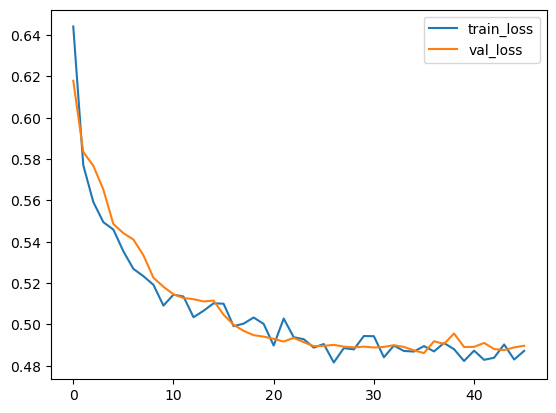

In [66]:
opt_dhs.training_log_.plot()

0.6424165773490532 0.6558595069233367


<Axes: >

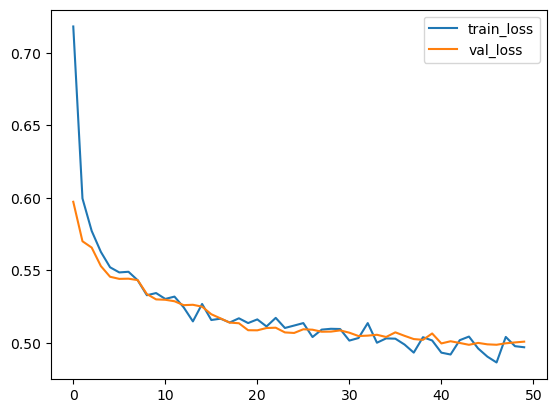

In [67]:
xplore=survhive.DeepHitSingle( **rez[1][4])
xplore.fit(X_train,y_train)
print(xplore.score(X_train,y_train), xplore.score(X_test,y_test))
xplore.training_log_.plot()

## Note su metabric

1. Miglioramento molto marginale rispetto a Coxnet dei metodi deep.
2. Le migliori soluzioni si ottengono con già con un singolo strato nascosto.
3. Al crescere del sistema, **su CPU**, auton sembra più veloce di pycox.
4. Pycox: il dropout *sembra* dover crescere col numero di stari nascosti (e.g. 0.1 per layer)